In [217]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import os

%matplotlib inline

In [1]:
path = 'test_images/'

In [219]:
def readimg(path):
    return mpimg.imread(path)

In [220]:
def gray_binary(rgb_img, thresh=(200,255)):
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

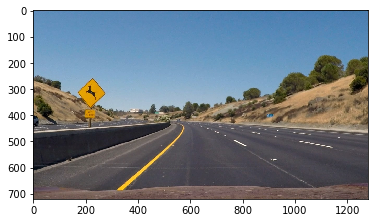

In [221]:
path_img = path + 'test2.jpg'
image = readimg(path_img)
img_plt(image)

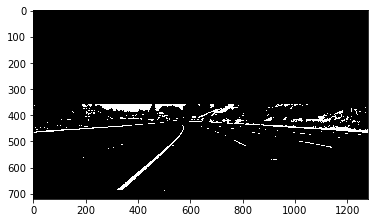

In [222]:
gray_thresh=(150,255)
gry_binary = gray_binary(image, gray_thresh)
gry_binary[0:gry_binary.shape[0]//2, :] = 0
img_plt(gry_binary,cmap='gray')

### Perspective transform

In [223]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[840,550],[1010,650],[300,650],[450,550]])
    dst = np.float32([[940,520],[940,650],[340,650],[340,520]])  
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

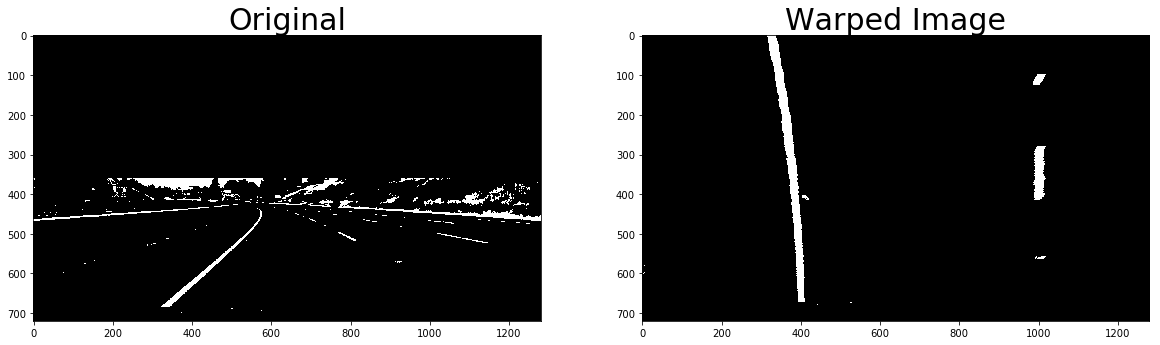

In [224]:
binary_warped, Minv = warp(gry_binary)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(gry_binary,cmap='gray')
ax1.set_title('Original', fontsize=30)
ax2.imshow(binary_warped,cmap='gray')
ax2.set_title('Warped Image', fontsize=30)
plt.show()

plt.imsave('test_images_output/test1_output_straight.jpg', binary_warped)

### Finding the Lines

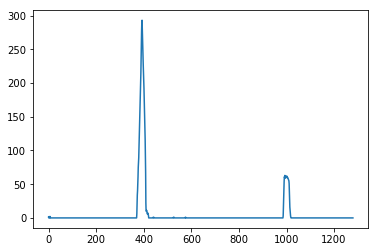

In [225]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

plt.plot(histogram)
plt.show()

In [226]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

In [227]:
# find the peak of the left and right halves of the histogram
# these will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# choose the number of sliding windows
nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# set the width of the windows +/- margin
margin = 100

# set minimum number of pixels found to recenter windown
minpix = 50
# create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# setp through the windows one by one
for window in range(nwindows):
    # identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # draw the windows on the visualization image
    cv2.rectangle(out_img, 
                  (win_xleft_low, win_y_low),
                  (win_xleft_high, win_y_high),
                  (0,255,0), 4)
    # draw the windows on the visualization image
    cv2.rectangle(out_img, 
                  (win_xright_low, win_y_low),
                  (win_xright_high, win_y_high),
                  (0,255,0), 4)
    
    # identify nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & 
                      (nonzeroy < win_y_high) &
                      (nonzerox >= win_xleft_low) & 
                      (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & 
                      (nonzeroy < win_y_high) &
                      (nonzerox >= win_xright_low) & 
                      (nonzerox < win_xright_high)).nonzero()[0]
    # append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # if found > minpix pixels, recenter the next window
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        right_current = np.int(np.mean(nonzerox[good_left_inds]))

# concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# fit a second order poly to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualization

(720, 0)

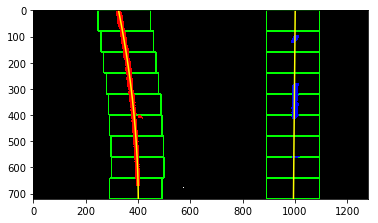

In [228]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]**ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)

### Skip the sliding windows step once you know where the lines are

In [229]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

### Visualization

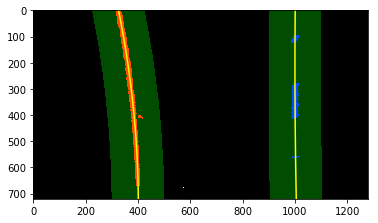

In [230]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Visualization

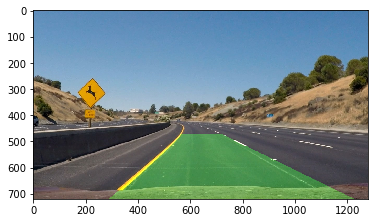

In [231]:
# binary_warped, ploty, left_fitx, right_fitx

def draw_result(image, warped, ploty, left_fitx, right_fitx, Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])   
    pts = np.hstack((pts_left, pts_right))
    
    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # warp the blank back to original image space using inverse perspective matrix
    newwarp = cv2.warpPerspective(color_warp, Minv,
                                  (image.shape[1], image.shape[0]))
    # combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

result = draw_result(image, binary_warped, ploty, left_fitx, right_fitx, Minv)

plt.imshow(result)
plt.show()